In [1]:
import torch
from load_data import *

In [2]:
device = torch.device('cuda:0')

# LoadDataset

In [3]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_compas_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

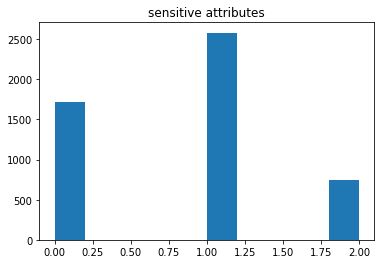

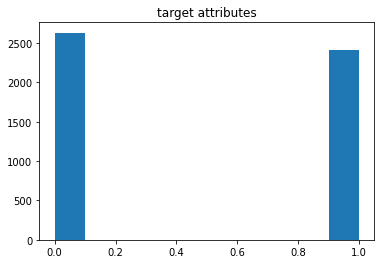

In [4]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [5]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.34085958]
training default:  [0.5214894]
test default:  [0.51270208]
# training samples: (5049, 7)
# test samples: (2165, 7)
# sensitive vars (5049, 1)
# output vars (5049, 1)


In [6]:
N1 = 300
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [7]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.34085958]
training init:  [0.56666667]
select init:  [0.5186355]
test default:  [0.51270208]


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [10]:
class Args:
    def __init__(self):
        self.epochs = 50
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [11]:
args = Args()

In [12]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)

In [13]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [14]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [15]:
from fairAL_utils import *

In [16]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
class BinaryEntropyLoss(nn.Module):
    def __init__(self):
        super(BinaryEntropyLoss,self).__init__()
    def forward(self,output):
        ent = -1.0*out

In [135]:
for i,(x,y,_) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
#     print(clf(x)[:,0]>0.5)
#     print(sum(y[:,0]==1).float()/y.size(0),y.size(0),sum(y[:,0]==1).float())
    if i>1:
        break

## compute gradient

In [18]:
clf.eval()

Classifier(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

- adversarial example jacobiab: https://github.com/ast0414/adversarial-example/blob/master/craft.py
- https://github.com/HIPS/autograd
- https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa 

In [23]:
for i,(x,y,_) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
#     print(clf(x)[:,0]>0.5)
#     print(sum(y[:,0]==1).float()/y.size(0),y.size(0),sum(y[:,0]==1).float())
    if i>1:
        break
grad_ent = auto_grad_entropy_test(clf,x)

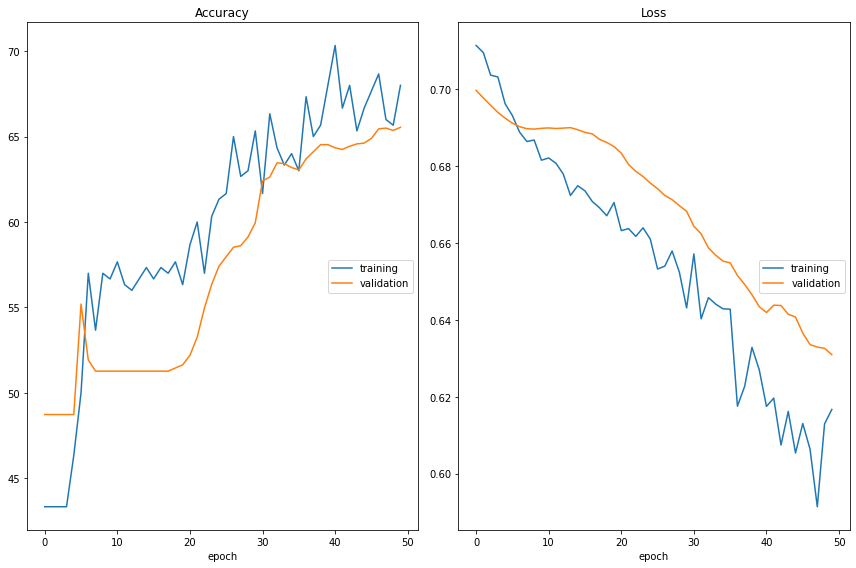

Accuracy
	training         	 (min:   43.333, max:   70.333, cur:   68.000)
	validation       	 (min:   48.730, max:   65.543, cur:   65.543)
Loss
	training         	 (min:    0.591, max:    0.711, cur:    0.617)
	validation       	 (min:    0.631, max:    0.700, cur:    0.631)
Finished Training


In [24]:
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
train_model(clf, train_loader, clf_criterion, clf_optimizer, device, args.epochs, test_loader, liveloss = None)

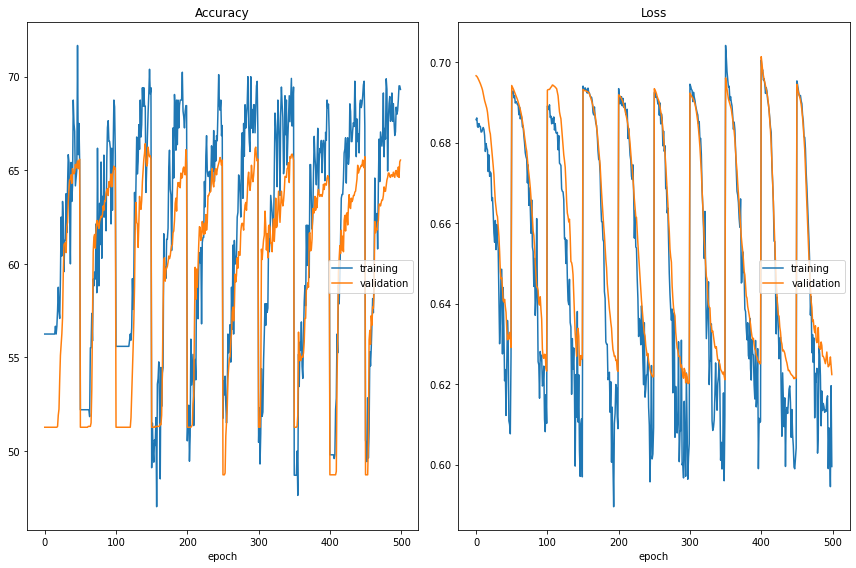

Accuracy
	training         	 (min:   47.024, max:   71.667, cur:   69.318)
	validation       	 (min:   48.730, max:   66.420, cur:   65.543)
Loss
	training         	 (min:    0.590, max:    0.704, cur:    0.600)
	validation       	 (min:    0.620, max:    0.701, cur:    0.622)
Finished Training


In [25]:
clf,f_train,f_select = train_AL_valid(train_loader, select_loader, device, args, test_loader, clf_type = 'NN',\
                                      from_scratch = True, sel_method = 'entropy',val_ratio = 0.2)

In [26]:
print("test performances")
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.6451916694641113 / acc 63.16507339477539
1.0 : loss 0.6150927543640137 / acc 66.21863555908203
2.0 : loss 0.595174252986908 / acc 68.67088317871094
(tensor(0.6224), tensor(65.5427))


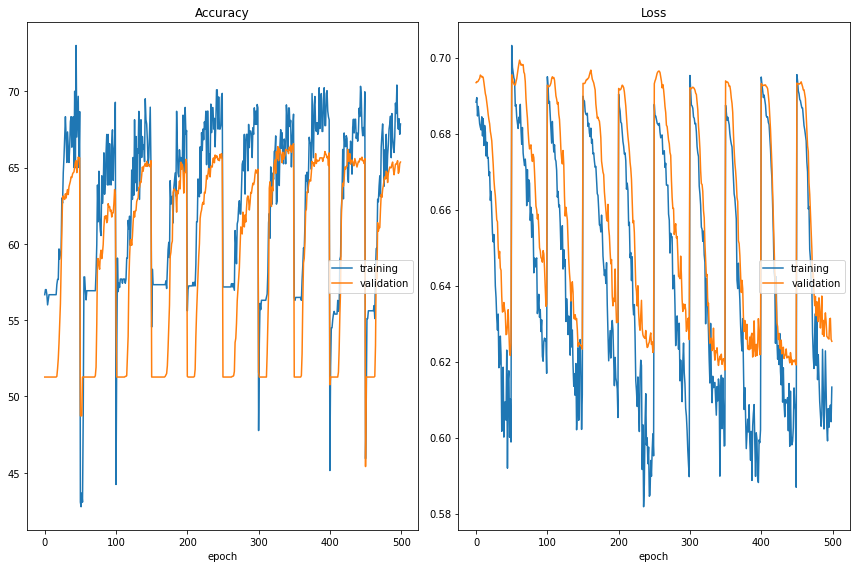

Accuracy
	training         	 (min:   42.771, max:   73.000, cur:   67.857)
	validation       	 (min:   45.404, max:   66.559, cur:   65.358)
Loss
	training         	 (min:    0.582, max:    0.703, cur:    0.613)
	validation       	 (min:    0.618, max:    0.699, cur:    0.625)
Finished Training


In [28]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, clf_type = 'NN',\
                    sel_method = 'random')

In [29]:
print("test performances")
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.657780110836029 / acc 61.39154052734375
1.0 : loss 0.6150949001312256 / acc 66.3978500366211
2.0 : loss 0.5862137675285339 / acc 70.88607788085938
(tensor(0.6253), tensor(65.3580))
